# Leios simulation analysis for CIP

## Set up

### Load packages

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: Testing hypotheses regarding throughput

In [2]:
readLines("sim-cli.hash")

[1] "sim-cli 1.3.1-66a2eb734"

### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/lifecycle.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
setnames(lifecycle, old="Kind", new="Message")
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


        Network          Bandwidth                CPU         
 topology-v2:4544238   10 Mb/s:4544238   4 vCPU/node:4544238  
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
        Diffusion duration          Voting duration      Max EB size     
 L_diff = 7 slots:4544238   L_vote = 4 slots:4544238   12 MB/EB:4544238  
                                                                         
                                                                         
                                                                         
                                                                         
                                                    

### Leios throughput is proportional to load until it plateaus when capacity is reached.

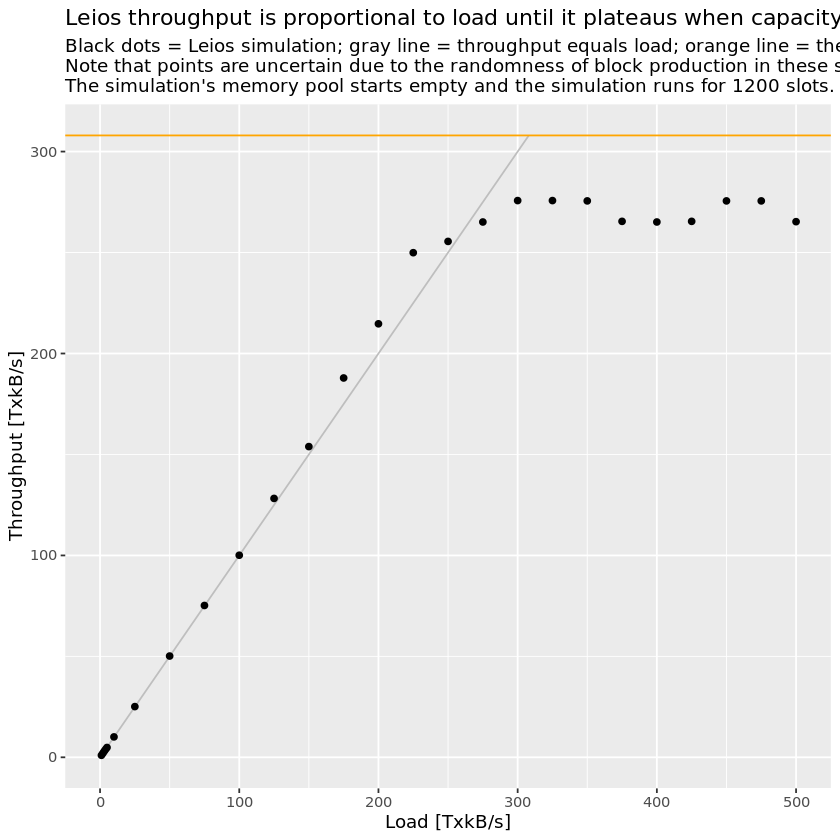

In [4]:
ggplot(
    lifecycle[
        `Message` == "TX" &
        (
            !is.na(`To RB [s]`) & `To RB [s]` >= 60 & `To RB [s]` <= 1200 |
            !is.na(`In RB [s]`) & `In RB [s]` >= 60 & `In RB [s]` <= 1200
        ),
        .(`Throughput [TxkB/s]`=sum(`Size [B]`)/(1200-60)/1000),
        .(
            `Load [TxkB/s]`=as.numeric(sub(" .*$", "", `Throughput`))*1000
        )
    ],
    aes(x=`Load [TxkB/s]`, y=`Throughput [TxkB/s]`)
) +
    geom_line(data=data.table(x=c(0,12/20*(1-0.05)^13)*1000, y=c(0,12/20*(1-0.05)^13)*1000), aes(x=`x`, y=`y`), color="gray") +
    geom_hline(yintercept=12/20*(1-0.05)^13*1000, color="orange") +
    geom_point() +
    xlim(0, NA) +
    ylim(0, NA) +
    ggtitle(
        "Leios throughput is proportional to load until it plateaus when capacity is reached.", 
        paste(
            "Black dots = Leios simulation; gray line = throughput equals load; orange line = theoretical limit on capacity.",
            "Note that points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "The simulation's memory pool starts empty and the simulation runs for 1200 slots.",
            sep="\n"
        )
    )

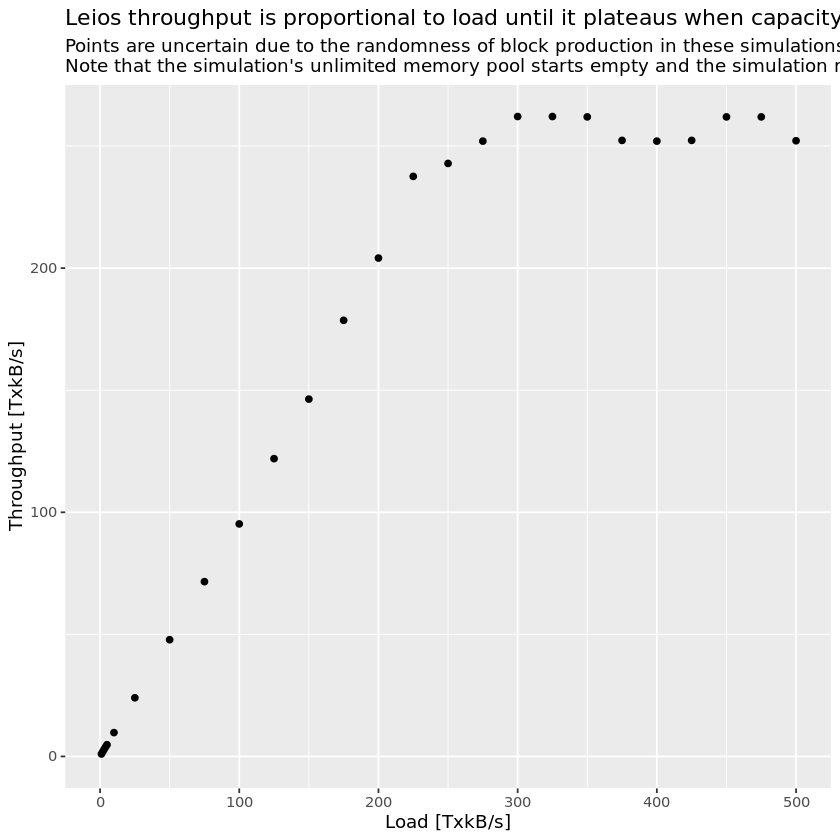

In [5]:
ggplot(
    lifecycle[
        `Message` == "TX" &
        (
            !is.na(`To RB [s]`) & `To RB [s]` >= 0 & `To RB [s]` <= 1200 |
            !is.na(`In RB [s]`) & `In RB [s]` >= 0 & `In RB [s]` <= 1200
        ),
        .(`Throughput [TxkB/s]`=sum(`Size [B]`)/(1200-0)/1000),
        .(
            `Load [TxkB/s]`=as.numeric(sub(" .*$", "", `Throughput`))*1000
        )
    ],
    aes(x=`Load [TxkB/s]`, y=`Throughput [TxkB/s]`)
) +
    geom_point() +
    xlim(0, NA) +
    ylim(0, NA) +
    ggtitle(
        "Leios throughput is proportional to load until it plateaus when capacity is reached.", 
        paste(
            "Points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "Note that the simulation's unlimited memory pool starts empty and the simulation runs for 1200 slots.",
            sep="\n"
        )
    )

In [6]:
ggsave("plots/load-throughput.png", units="in", dpi=150, width=10, height=6)

In [7]:
ggsave("plots/load-throughput.svg", units="in", dpi=150, width=10, height=6)

### The variability of delivery times plateaus until capacity is reached.

In [8]:
quantiles <- function(created, toRB, inRB) {
    xs <- mapply(
        function(c, t, i) {
            if (is.na(t))
                i - c
            else
                t - c
        }, created, toRB, inRB)
    qs <- c(0.10, 0.50, 0.90)
    quantile(xs, qs) %>% as.numeric
}

In [9]:
lifecycle1 <-
    lifecycle[
        `Message` == "TX" &
        (
            !is.na(`To RB [s]`) & `To RB [s]` >= 0 & `To RB [s]` <= 1200 |
            !is.na(`In RB [s]`) & `In RB [s]` >= 0 & `In RB [s]` <= 1200
        ),
        .(
            `Quantile`=factor(c("10%", "50%", "90%")),
            `Mempool-to-ledger for transactions [s]`=quantiles(`Created [s]`, `To RB [s]`, `In RB [s]`)
        ),
        by=.(
            `Load [TxkB/s]`=as.numeric(sub(" .*$", "", `Throughput`))*1000
        )
    ]

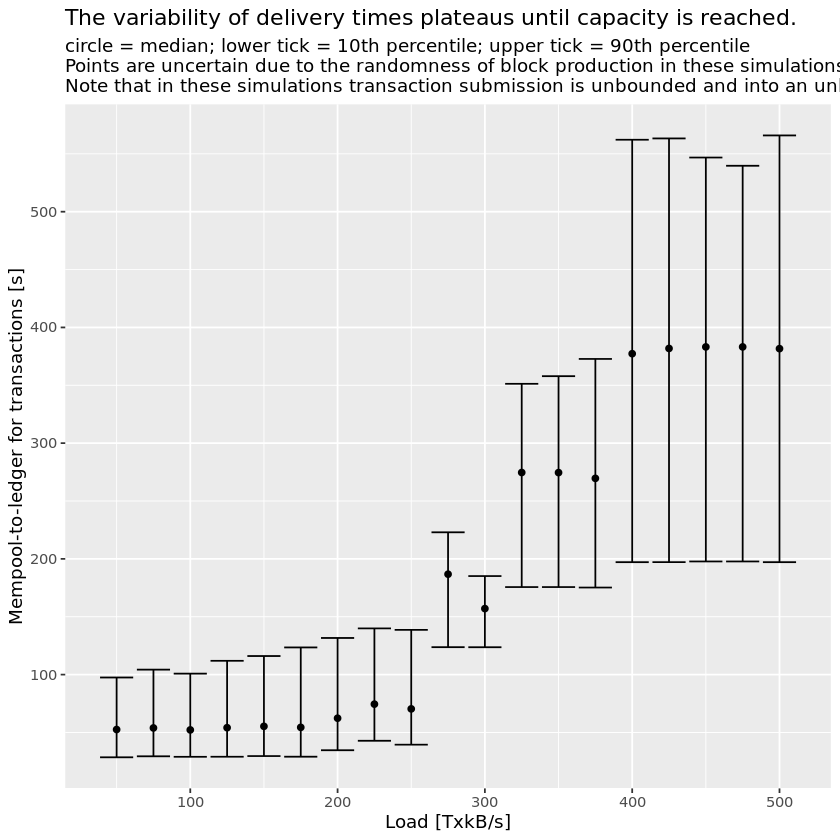

In [10]:
ggplot(
    dcast(
        lifecycle1[`Load [TxkB/s]` >= 50], 
        `Load [TxkB/s]` ~ `Quantile`, 
        value.var="Mempool-to-ledger for transactions [s]"
    ),
    aes(x=`Load [TxkB/s]`)
) +
    geom_errorbar(aes(x=`Load [TxkB/s]`, ymin=`10%`, ymax=`90%`)) +
    geom_point(aes(x=`Load [TxkB/s]`, y=`50%`)) +
    ylab("Mempool-to-ledger for transactions [s]") +
    ggtitle(
        "The variability of delivery times plateaus until capacity is reached.", 
        paste(
            "circle = median; lower tick = 10th percentile; upper tick = 90th percentile",
            "Points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "Note that in these simulations transaction submission is unbounded and into an unlimited memory pool.",
            sep="\n"
        )
    )

In [11]:
ggsave("plots/load-txvariance.png", units="in", dpi=150, width=10, height=6)

In [12]:
ggsave("plots/load-txvariance.svg", units="in", dpi=150, width=10, height=6)

### Transaction delay to ledger for Leios vs Praos

In [13]:
minna <- function(x, y) {
    if (is.na(x) & is.na(y))
        NA
    else
        min(x, y, na.rm=TRUE)
}

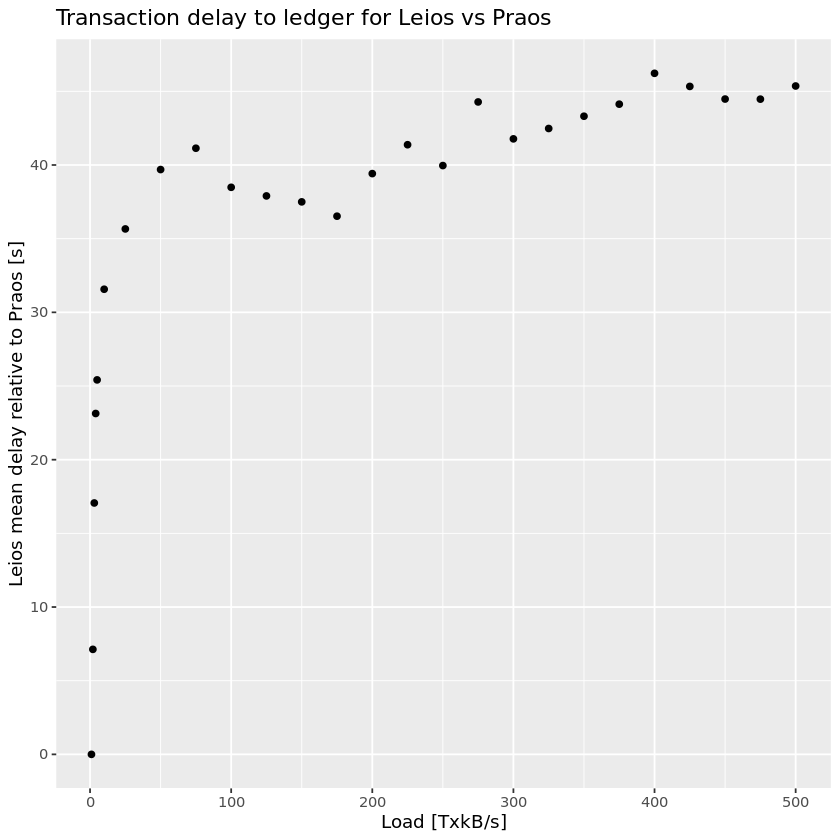

In [14]:
ggplot(
    lifecycle[
        `Message` == "TX" & (!is.na(`To RB [s]`) | !is.na(`In RB [s]`)),
        .(`Leios mean delay relative to Praos [s]`=mean(mapply(minna, `To RB [s]`, `In RB [s]`) - mapply(minna, `To EB [s]`, `In RB [s]`))),
        .(`Load [TxkB/s]`=as.numeric(sub(" .*$", "", `Throughput`))*1000)
    ],
    aes(x=`Load [TxkB/s]`, y=`Leios mean delay relative to Praos [s]`, group=`Load [TxkB/s]`)
) +
    geom_point() +
    ggtitle("Transaction delay to ledger for Leios vs Praos")

In [15]:
ggsave("plots/load-delay.png", units="in", dpi=150, width=10, height=6)

In [16]:
ggsave("plots/load-delay.svg", units="in", dpi=150, width=10, height=6)

### Read resource data

In [17]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
    save(lifecycle, sampleSize, file="results/resources.Rdata")
    cat(paste("Saved Rdata file: sampleSize =", sampleSize, "\n"))
}
resources %>% summary

Loaded Rdata file: sampleSize = 1 


        Network        Bandwidth              CPU       
 topology-v2:19500   10 Mb/s:19500   4 vCPU/node:19500  
                                                        
                                                        
                                                        
                                                        
                                                        
                                                        
        Diffusion duration         Voting duration    Max EB size   
 L_diff = 7 slots:19500    L_vote = 4 slots:19500   12 MB/EB:19500  
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                             

### The cost of processing per transaction either remains the same or goes down as the load goes up.

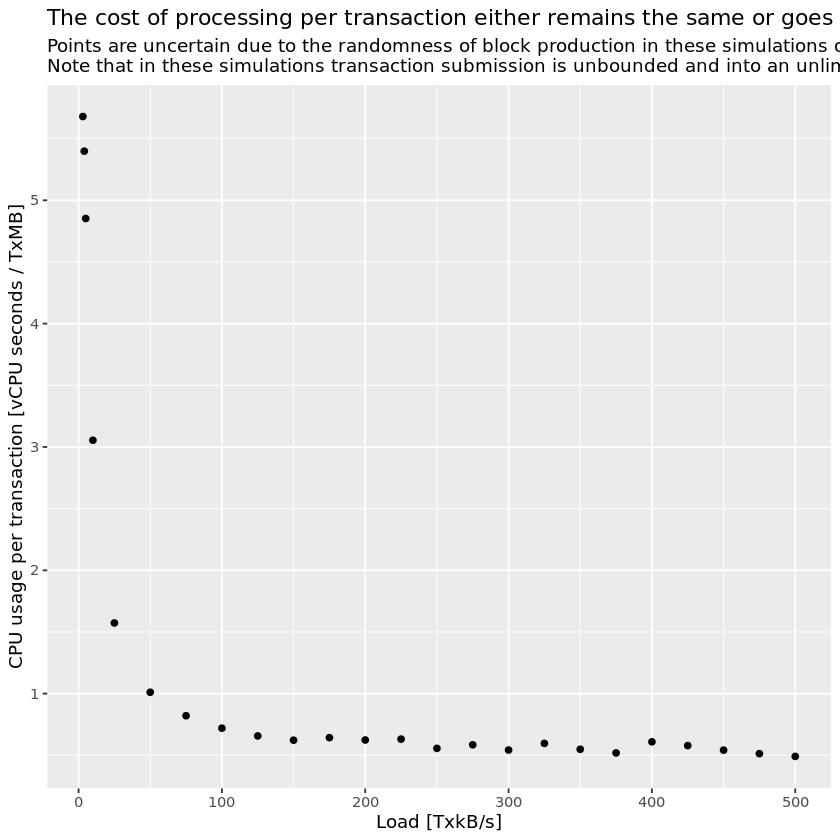

In [18]:
ggplot(
    resources[
        !(`Throughput` %in% c("0.001 TxMB/s", "0.002 TxMB/s")),
        .(
            `CPU usage per transaction [vCPU seconds / TxMB]`=sum(`Total CPU [s]`) / sum(1200 * as.numeric(sub(" .*$","",`Throughput`)))
        ),
        .(
            `Load [TxkB/s]`=1000 * as.numeric(sub(" .*$", "", `Throughput`))
        )
    ],
    aes(x=`Load [TxkB/s]`, y=`CPU usage per transaction [vCPU seconds / TxMB]`)
) +
    geom_point() +
    ggtitle(
        "The cost of processing per transaction either remains the same or goes down as the load goes up.",
        paste(
            "Points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "Note that in these simulations transaction submission is unbounded and into an unlimited memory pool.",
            sep="\n"
        )
    )

In [19]:
ggsave("plots/load-cpu.png", units="in", dpi=150, width=10, height=6)

In [20]:
ggsave("plots/load-cpu.svg", units="in", dpi=150, width=10, height=6)

### The cost of processing per transaction either remains the same or goes down as the load goes up.

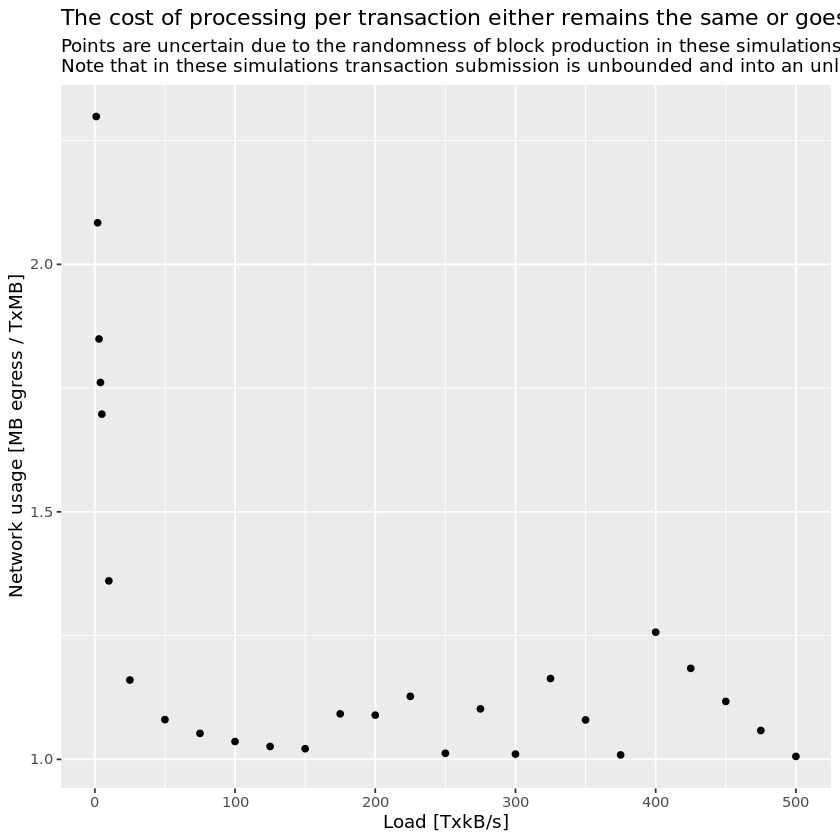

In [21]:
ggplot(
    resources[
        ,
        .(
            `Network usage [MB egress / TxMB]`=sum(`Egress [B]` / 1000000) / sum(1200 * as.numeric(sub(" .*$","",`Throughput`)))
        ),
        .(
            `Load [TxkB/s]`=1000 * as.numeric(sub(" .*$", "", `Throughput`))
        )
    ],
    aes(x=`Load [TxkB/s]`, y=`Network usage [MB egress / TxMB]`)
) +
    geom_point() +
    ggtitle(
        "The cost of processing per transaction either remains the same or goes down as the load goes up.",
        paste(
            "Points are uncertain due to the randomness of block production in these simulations of 20 minutes.",
            "Note that in these simulations transaction submission is unbounded and into an unlimited memory pool.",
            sep="\n"
        )
    )

In [22]:
ggsave("plots/load-egress.png", units="in", dpi=150, width=10, height=6)

In [23]:
ggsave("plots/load-egress.svg", units="in", dpi=150, width=10, height=6)